In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

In [2]:

# === LOAD DATA ===
#file_path = "D:/KULIAH/SEMESTER 6/DEEP LEARNING/TUGAS/TUGAS BESAR/dfTransjakarta.csv"

file_path = "dfTransjakarta.csv"
df = pd.read_csv(file_path)

# === PREPROCESSING ===
df['tapInTime'] = pd.to_datetime(df['tapInTime'])
df['tapOutTime'] = pd.to_datetime(df['tapOutTime'])
df['trip_duration_minutes'] = (df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60
df['tapInHour'] = df['tapInTime'].dt.hour
df['tapInDate'] = df['tapInTime'].dt.date

# Hitung kepadatan penumpang
density = df.groupby(['corridorID', 'tapInDate', 'tapInHour']).size().reset_index(name='passenger_density')
df = pd.merge(df, density, on=['corridorID', 'tapInDate', 'tapInHour'], how='left')

# Aggregasi per waktu
agg_df = df.groupby(['corridorID', 'tapInDate', 'tapInHour']).agg({
    'trip_duration_minutes': 'mean',
    'passenger_density': 'sum'
}).reset_index()

agg_df['timestamp'] = pd.to_datetime(agg_df['tapInDate'].astype(str)) + pd.to_timedelta(agg_df['tapInHour'], unit='h')
agg_df = agg_df.sort_values(by=['corridorID', 'timestamp'])

# === SCALING DENGAN ROBUSTSCALER ===
scaler = RobustScaler()
agg_df[['trip_duration_minutes', 'passenger_density']] = scaler.fit_transform(
    agg_df[['trip_duration_minutes', 'passenger_density']]
)

# === SEQUENCE PREPARATION ===
def create_sequences(data, look_back=5):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, :])
        y.append(data[i+look_back, :])
    return np.array(X), np.array(y)

features = agg_df[['trip_duration_minutes', 'passenger_density']].values
features = np.nan_to_num(features)  # Hapus NaN/infinite

X, y = create_sequences(features, look_back=5)
y = np.nan_to_num(y)  # Pastikan y tidak mengandung NaN/inf

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === MODEL RNN ===
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),     # (timesteps, features)
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(2)  # Output: [durasi, kepadatan]
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# === TRAINING ===
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop])


Epoch 1/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6749 - mae: 0.5573 - val_loss: 0.5457 - val_mae: 0.5483
Epoch 2/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6699 - mae: 0.5667 - val_loss: 0.5448 - val_mae: 0.5462
Epoch 3/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6604 - mae: 0.5680 - val_loss: 0.5436 - val_mae: 0.5368
Epoch 4/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6372 - mae: 0.5578 - val_loss: 0.5448 - val_mae: 0.5353
Epoch 5/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6429 - mae: 0.5585 - val_loss: 0.5425 - val_mae: 0.5500
Epoch 6/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6402 - mae: 0.5575 - val_loss: 0.5430 - val_mae: 0.5454
Epoch 7/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6214 - mae: 0.5548 - val_loss: 0.5441 - val_mae: 0.5493
Epoch 8/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6512 - mae: 0.5587 - val_loss: 0.5427 - val_mae: 0.5409
Epoch 9/50
539/539 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [3]:
# ===================== Evaluate =====================
loss, mae = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}, Test MAE: {mae:.4f}")

y_pred = model.predict(X_test)
combined = np.vstack((y_pred, y_test))
combined_original = scaler.inverse_transform(combined)

y_pred_original = combined_original[:len(y_pred)]
y_test_original = combined_original[len(y_pred):]


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5582 - mae: 0.5517

Test Loss: 0.6079, Test MAE: 0.5613
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


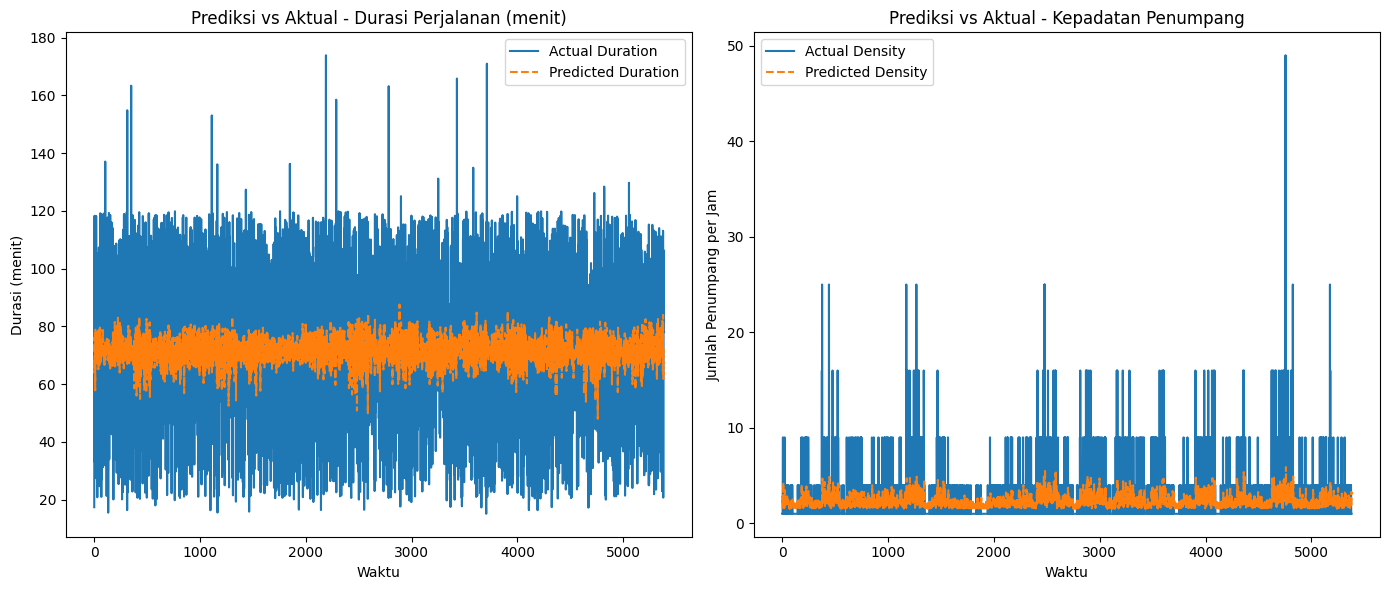

In [4]:
# ===================== Visualisasi Prediksi =====================
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_test_original[:, 0], label='Actual Duration')
plt.plot(y_pred_original[:, 0], label='Predicted Duration', linestyle='dashed')
plt.title('Prediksi vs Aktual - Durasi Perjalanan (menit)')
plt.xlabel('Waktu')
plt.ylabel('Durasi (menit)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_original[:, 1], label='Actual Density')
plt.plot(y_pred_original[:, 1], label='Predicted Density', linestyle='dashed')
plt.title('Prediksi vs Aktual - Kepadatan Penumpang')
plt.xlabel('Waktu')
plt.ylabel('Jumlah Penumpang per Jam')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
# ===================== Analisis Kepadatan per Jam =====================
jam_df = df.groupby('tapInHour')['passenger_density'].mean().reset_index()
jam_df.columns = ['Jam', 'Rata-rata Kepadatan']
threshold = jam_df['Rata-rata Kepadatan'].median()

jam_df['Kategori'] = jam_df['Rata-rata Kepadatan'].apply(
    lambda x: 'Ramai' if x > threshold else 'Tidak Ramai'
)

print("\n Kepadatan Penumpang per Jam:")
print(jam_df)



 Kepadatan Penumpang per Jam:
    Jam  Rata-rata Kepadatan     Kategori
0     5             1.610734        Ramai
1     6             2.152440        Ramai
2     7             1.569845        Ramai
3     8             1.556112        Ramai
4     9             1.570692        Ramai
5    10             1.131488  Tidak Ramai
6    11             1.085627  Tidak Ramai
7    12             1.092593  Tidak Ramai
8    13             1.115942  Tidak Ramai
9    14             1.080460  Tidak Ramai
10   15             1.206718  Tidak Ramai
11   16             1.576627        Ramai
12   17             2.061186        Ramai
13   18             1.437950  Tidak Ramai
14   19             1.467313        Ramai
15   20             1.463918  Tidak Ramai
16   21             1.428226  Tidak Ramai


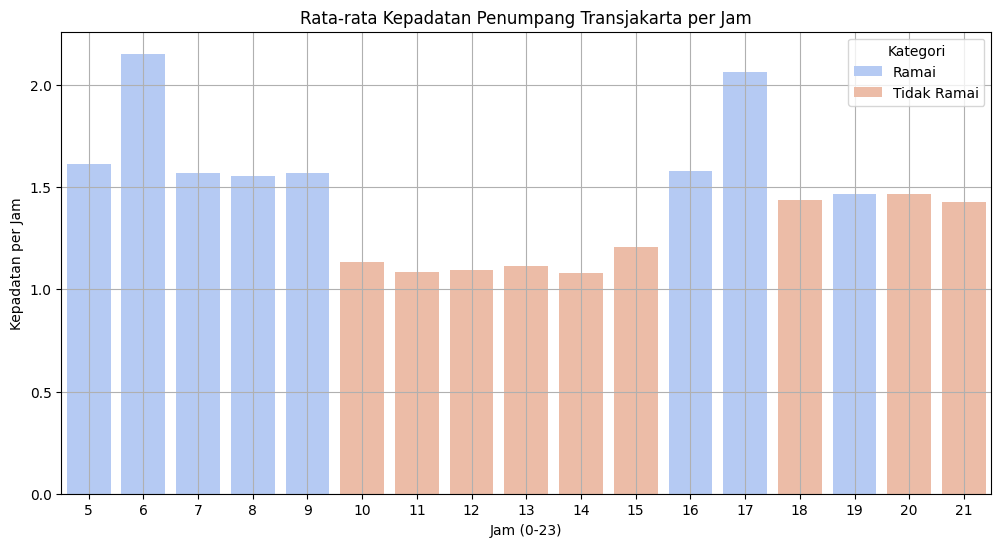

In [6]:
# ===================== Visualisasi Bar Chart Jam Ramai =====================
plt.figure(figsize=(12, 6))
sns.barplot(x='Jam', y='Rata-rata Kepadatan', hue='Kategori', data=jam_df, palette='coolwarm')
plt.title('Rata-rata Kepadatan Penumpang Transjakarta per Jam')
plt.xlabel('Jam (0-23)')
plt.ylabel('Kepadatan per Jam')
plt.legend(title='Kategori')
plt.grid(True)
plt.show()


C:\Users\rafie\AppData\Local\Temp\ipykernel_22312\3102610507.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Corridor ID', y='Rata-rata Durasi (menit)', data=top10_durasi, palette='magma')


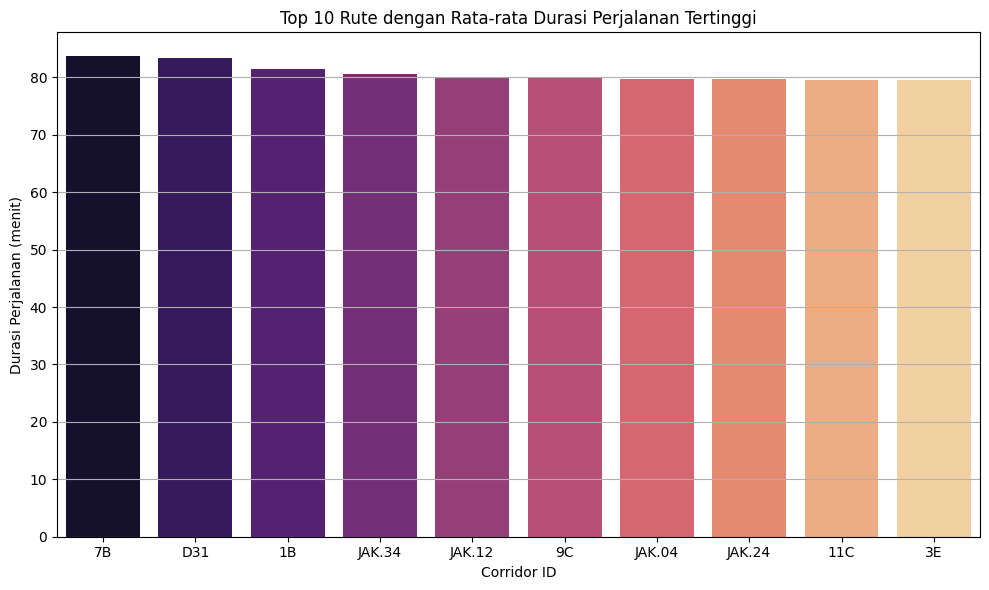

In [7]:
# ===================== 11. Visualisasi 10 Rute dengan Durasi Tertinggi =====================
top10_durasi = df.groupby('corridorID')['trip_duration_minutes'].mean().reset_index()
top10_durasi.columns = ['Corridor ID', 'Rata-rata Durasi (menit)']
top10_durasi = top10_durasi.sort_values(by='Rata-rata Durasi (menit)', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Corridor ID', y='Rata-rata Durasi (menit)', data=top10_durasi, palette='magma')
plt.title('Top 10 Rute dengan Rata-rata Durasi Perjalanan Tertinggi')
plt.xlabel('Corridor ID')
plt.ylabel('Durasi Perjalanan (menit)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
